In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [152]:
### define transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [153]:
### define transforms
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [154]:
root = "AorD"

train_data = datasets.ImageFolder(os.path.join(root,"train"),transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,"test"),transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data , batch_size=10,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data , batch_size=10,shuffle=False,pin_memory=True)

class_names = train_data.classes

print(class_names)
print(len(train_data))
print(len(test_data))


['animal_crossing', 'doom']
1597
461


In [155]:
## MODEL

In [180]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.conv3 = nn.Conv2d(16,32,3,1)
        self.fc1 = nn.Linear(26*26*32,120)
        self.d_out = nn.Dropout2d(p=0.3)
        self.fc2 = nn.Linear(120,84)
        self.out = nn.Linear(84,2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,26*26*32)
        x = F.relu(self.fc1(x))
        x = self.d_out(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return F.log_softmax(x,dim=1)

In [181]:
torch.manual_seed(42)
model = cnn().cuda()

In [182]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

In [183]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [184]:
count_parameters(model)

     162
       6
     864
      16
    4608
      32
 2595840
     120
   10080
      84
     168
       2
________
 2611982


In [185]:
import time
start_time = time.time()

epochs = 4

train_losses = []
test_losses= []
train_correct  = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):
        
        b+=1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        
        for b, (X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            loss = criterion(y_val,y_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
        

epoch:  0  batch:   20 [   200/8000]  loss: 0.75721502  accuracy:  47.500%
epoch:  0  batch:   40 [   400/8000]  loss: 0.79070294  accuracy:  50.000%
epoch:  0  batch:   60 [   600/8000]  loss: 0.67974466  accuracy:  50.167%
epoch:  0  batch:   80 [   800/8000]  loss: 0.70673496  accuracy:  50.500%
epoch:  0  batch:  100 [  1000/8000]  loss: 0.67120403  accuracy:  50.300%
epoch:  0  batch:  120 [  1200/8000]  loss: 0.67105019  accuracy:  50.417%
epoch:  0  batch:  140 [  1400/8000]  loss: 0.68310380  accuracy:  50.786%
epoch:  0  batch:  160 [  1600/8000]  loss: 0.67623681  accuracy:  51.375%
epoch:  1  batch:   20 [   200/8000]  loss: 0.69832689  accuracy:  52.000%
epoch:  1  batch:   40 [   400/8000]  loss: 0.69733071  accuracy:  50.750%
epoch:  1  batch:   60 [   600/8000]  loss: 0.69321501  accuracy:  50.000%
epoch:  1  batch:   80 [   800/8000]  loss: 0.64201891  accuracy:  51.625%
epoch:  1  batch:  100 [  1000/8000]  loss: 0.79911608  accuracy:  52.400%
epoch:  1  batch:  120 [ 

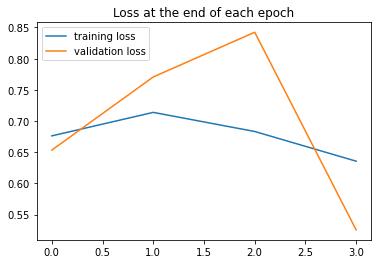

In [186]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [187]:
###Alexnet

In [202]:
alex = models.alexnet(pretrained=True)


In [203]:
for param in alex.parameters():
    param.requires_grad=False

In [204]:
torch.manual_seed(42)
alex.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))


In [205]:
alex= alex.cuda()

In [207]:
count_parameters(alex)

 9437184
    1024
    2048
       2
________
 9440258


In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alex.classifier.parameters(), lr=0.001)

In [209]:
import time
start_time = time.time()

epochs = 4

train_losses = []
test_losses= []
train_correct  = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):
        
        b+=1
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        
        y_pred = alex(X_train)
        loss = criterion(y_pred,y_train)
        
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        
        for b, (X_test,y_test) in enumerate(test_loader):
            
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = alex(X_test)
            loss = criterion(y_val,y_test)
            
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed
        

epoch:  0  batch:   20 [   200/8000]  loss: 0.71269637  accuracy:  61.000%
epoch:  0  batch:   40 [   400/8000]  loss: 0.18093708  accuracy:  68.500%
epoch:  0  batch:   60 [   600/8000]  loss: 0.12811108  accuracy:  71.333%
epoch:  0  batch:   80 [   800/8000]  loss: 0.69765729  accuracy:  73.000%
epoch:  0  batch:  100 [  1000/8000]  loss: 0.26462787  accuracy:  75.100%
epoch:  0  batch:  120 [  1200/8000]  loss: 0.19065423  accuracy:  76.417%
epoch:  0  batch:  140 [  1400/8000]  loss: 0.20983148  accuracy:  76.500%
epoch:  0  batch:  160 [  1600/8000]  loss: 0.35111877  accuracy:  77.062%
epoch:  1  batch:   20 [   200/8000]  loss: 0.77068865  accuracy:  82.000%
epoch:  1  batch:   40 [   400/8000]  loss: 0.11179534  accuracy:  86.500%
epoch:  1  batch:   60 [   600/8000]  loss: 0.19747441  accuracy:  86.000%
epoch:  1  batch:   80 [   800/8000]  loss: 0.44873041  accuracy:  85.750%
epoch:  1  batch:  100 [  1000/8000]  loss: 0.15612909  accuracy:  86.000%
epoch:  1  batch:  120 [ 

In [213]:
# DON'T WRITE HERE
alex.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        X_test =X_test.cuda()
        y_test = y_test.cuda()
        y_val = alex(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 435/461 =  94.360%


In [217]:
import pickle
alex = alex.cpu()
with open("binary_list.bin","wb") as f:
    pickle.dump(alex, f)
